In [5]:
import numpy as np
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
import ibapi
from datetime import datetime
from ibapi.contract import Contract
from ibapi.order import Order
from ibapi.order_condition import Create, OrderCondition
from ibapi.common import TickAttrib, SetOfString, SetOfFloat

import threading
import multiprocessing
import time

import logging

# logging.basicConfig(level=logging.ERROR)

In [6]:
ibapi.get_version_string()

'10.19.4'

In [7]:
"""Ibapi Class that inherits from both EWrapper and EClient."""

from decimal import Decimal

from ibapi.client import EClient
from ibapi.common import TickAttrib
from ibapi.contract import Contract, ContractDetails
from ibapi.execution import Execution
from ibapi.order import Order
from ibapi.order_state import OrderState
from ibapi.wrapper import EWrapper
from loguru import logger

from trading.core.data_models.data_models import StockInfo


class IBapi(EWrapper, EClient):
    """Ibapi Class that inherits from both EWrapper and EClient. This is where the logic for handling incoming messages
    through the Ewrapper happens.
    """

    def __init__(self) -> None:
        """Define variables to be assigned returned value from the Ewrapper"""
        EClient.__init__(self, self)

        # orders details dict
        self.order_status: dict = {}
        # order execution details
        self.execution_details: dict = {}

        # next valid order
        self.nextorderId: int | None = None

        # contract details for options and stocks
        self.options_price_dict: dict = {}
        self.stocks_price_dict: dict = {}

        # contract details for options and stocks
        self.options_strike_price_dict: dict = {}
        self.stocks_strike_price_dict: dict = {}

        # data structure to hold current price requests
        self.current_asset_price_dict: dict = {}
            
        # historical data
        self.historical_data_onlyrth = []
        
        # data counter
        self.current_day = None
        
    def nextValidId(self, orderId: int | None) -> None:
        """Callback function to update the next valid order id"""
        self.nextorderId = orderId
        logger.info(f"The next valid order id is: {self.nextorderId}.")
        
    def historicalData(self, reqId: int, bar):
        self.historical_data_onlyrth.append(bar)
        # print(bar)
        
        current_day = bar.date.split(" ")[0]
        if self.current_day is None:
            self.current_day = current_day
            print(f"Processing for day {self.current_day}...")
        else:
            if current_day != self.current_day:
                self.current_day = current_day
                print(f"Processing for day {self.current_day}...")
        

    def contractDetails(self, reqId: int, contractDetails: ContractDetails) -> None:
        """Callback function to receive contract details for option (OPT) type contracts."""
        contract = contractDetails.contract

        # we use a different dict to store options and stocks data
        if contract.secType == "OPT":
            if contract.symbol not in self.options_strike_price_dict.keys():
                self.options_strike_price_dict[contract.symbol] = []
            self.options_strike_price_dict[contract.symbol].append(contract.strike)

        elif contract.secType == "STK":
            if reqId not in self.stocks_strike_price_dict.keys():
                self.stocks_strike_price_dict[reqId] = []
            self.stocks_strike_price_dict[reqId].append(contract)

    # def get_open_order_status(self) -> None:
    #     """Trigger the orderStatus EWrapper callback function."""
    #     self.order_status = {}  # reset the dictionary
    #     self.reqOpenOrders()

    def openOrder(self, orderId: int, contract: Contract, order: Order, orderState: OrderState) -> None:
        """Overwrite Ewrapper openOrder callback function."""
        logger.info(f'''openOrder id:, {orderId}, {contract.symbol}, {contract.secType}, @, {contract.exchange}, ':',
                    {order.action}, {order.orderType}, {order.totalQuantity}, {orderState.status}.''')

    def execDetails(self, reqId: int, contract: Contract, execution: Execution) -> None:
        """Overwrite Ewrapper execDetails callback function."""
        logger.info(f'''Order Executed: {reqId}, {contract.symbol}, {contract.secType}, {contract.currency}, {execution.execId},
        {execution.orderId}, {execution.shares}, {execution.lastLiquidity}.''')
        self.execution_details[execution.orderId] = {"contract": contract, "execution": execution}

    def orderStatus(self, orderId: int, status: str, filled: Decimal, remaining: Decimal, avgFullPrice: float,
                    permId: int, parentId: int, lastFillPrice: float, clientId: int, whyHeld: str,
                    mktCapPrice: float) -> None:
        """Overwrite Ewrapper orderStatus callback function."""
        logger.info(f'''orderStatus - orderid: {orderId}, status:, {status}, filled, {filled}, remaining, {remaining},
                    lastFillPrice, {lastFillPrice}''')
        self.order_status[orderId] = {"status": status, "filled": filled, "remaining": remaining}

    def tickPrice(self, reqId: int, tickType: int, price: float, attrib: TickAttrib) -> None:
        """Callback function to obtain tickprice information when calling RqtMktData Eclient function."""
        if reqId not in self.current_asset_price_dict.keys():
            self.current_asset_price_dict[reqId] = StockInfo()
        if tickType == 1 or tickType == 2:

            # Initialize the price list if it is None
            if self.current_asset_price_dict[reqId].price is None:
                self.current_asset_price_dict[reqId].price = []

            # Append the new price to the list
            self.current_asset_price_dict[reqId].price.append(price)

            spread_side = "bid"
            if tickType == 2:
                spread_side = "ask"
            logger.info(f'The current {spread_side} price is: {price} for reqId {reqId}.')

    def marketDataType(self, reqId: int, marketDataType: int) -> None:
        """Ewrapper method to receive if market data is live/delayed/frozen from reqMktData()."""
        if reqId not in self.current_asset_price_dict.keys():
            self.current_asset_price_dict[reqId] = StockInfo()
        if marketDataType == 1:
            # Append the new price to the list
            self.current_asset_price_dict[reqId].market_is_live = True

            logger.info(
                f'Live data is: {True} for reqId {reqId}.')


In [8]:
def run_loop() -> None:
    app.run()

app = IBapi()
app.connect("127.0.0.1", 7497, 0)

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

2024-08-10 15:24:48.708 | INFO     | __main__:nextValidId:54 - The next valid order id is: 1.
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Processing for day 20240805...
Processing for day 20240806...
Processing for day 20240807...
Processing for day 20240808...
Processing for day 20240809...


In [5]:
app.nextorderId

1

In [10]:
app.disconnect()

# create contract objects

In [13]:
# create options contract object

def get_options_contract(ticker: str, contract_strike: int | str = "", 
                         expiry_date: str = datetime.now().strftime("%Y%m%d"), right: str = "C"):
    
    contract = Contract()
    contract.symbol = ticker
    contract.secType = "OPT"
    contract.exchange = "SMART"
    contract.currency = "USD"
    contract.strike = contract_strike
    contract.lastTradeDateOrContractMonth = expiry_date
    contract.right = right
    contract.multiplier = 100
    
    return contract

In [14]:
# Create stock contract object

def get_stock_contract(ticker: str):
    contract = Contract()
    contract.symbol = ticker
    contract.secType = 'STK'
    contract.exchange = 'SMART'
    contract.currency = 'USD'
    
    return contract

# create option order

In [15]:
def create_option_order(order_id: int, action: str, price: float, quantity: int = 1) -> Order:
    """Implements option order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of options)
    """
    order = Order()
    order.orderId = order_id
    order.action = action
    order.tif = "DAY"
    order.totalQuantity = quantity
    order.orderType = 'LMT'
    order.lmtPrice = price
    order.allOrNone = True

    return order

# Create stock order

In [16]:
def create_parent_order(order_id: int, action: str, price: float, quantity: int, all_or_none: bool = True) -> Order:
    """Implements stock order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    order = Order()
    order.orderId = order_id
    order.action = action
    order.tif = "DAY"
    order.totalQuantity = quantity
    order.orderType = 'LMT'
    order.lmtPrice = price
    order.allOrNone = all_or_none
    order.outsideRth = True

    return order


def create_child_order(parent_order_id: int, child_order_id: int,
                       action: str, price: float, quantity: int, all_or_none: bool = True) -> Order:
    """Implements stock order.
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    order = Order()
    order.orderId = child_order_id
    order.parentId = parent_order_id
    order.action = action
    order.tif = "DAY"
    order.totalQuantity = quantity
    order.orderType = 'LMT'
    order.lmtPrice = price
    order.allOrNone = all_or_none
    order.outsideRth = True

    return order

# Place order

In [17]:
from ibapi.contract import Contract
from ibapi.order_condition import Create, OrderCondition, PriceCondition

In [18]:
"""Create conditions for conditional orders"""

def create_price_condition(contract: Contract, isMore: bool, price_condition: float) -> PriceCondition:
    """Create price condition."""
    condition = Create(OrderCondition.Price)
    condition.conId = contract.conId
    condition.exchange = contract.exchange
    condition.isMore = isMore  # if True, the order is triggered when the price goes above our condition.price
    condition.triggerMethod = condition.TriggerMethodEnum.Last
    condition.price = price_condition

    print(condition.conId)
    print(condition.exchange)
    
    return condition

In [19]:
def place_simple_order(app: IBapi, contract: Contract, action: str, price: float, quantity: int,
                       price_condition: PriceCondition = None) -> None:
    """Place a limit order.
    action: str (SELL OR BUY)
    price: float (price for the limit order)
    quantity: int (number of shares)
    """
    if action == "BUY":
        price += config_vars["buffer_allowed_pennies"]
    elif action == "SELL":
        price -= config_vars["buffer_allowed_pennies"]
    else:
        raise ValueError(f"Valid actions are [BUY, SELL], got {action}.")

    order = create_parent_order(app.nextorderId,  # type: ignore
                                action,
                                round(price, 2),
                                quantity)

    if price_condition is not None:
        order.conditions.append(price_condition)

    order.transmit = True
    app.placeOrder(app.nextorderId, contract, order)
    app.nextorderId += 1  # type: ignore


In [20]:
def place_conditional_parent_child_orders(app: IBapi, contract: Contract, price: float) -> None:
    """Place a parent conditional buy order based on price and an attached conditional child order, also based on price.
    This is part of implementing the itm dynamic hedging strategy.
    """
    # create a sell order for stocks if price condition is met (price reaches the strike price)
    parent_price_condition = create_price_condition(contract, False, price)
    parent_order = create_parent_order(app.nextorderId,  # type: ignore
                                       "SELL",
                                       price,
                                       100,
                                       False)
    parent_order.conditions.append(parent_price_condition)
    parent_order.transmit = True

    app.placeOrder(app.nextorderId, contract, parent_order)
    app.nextorderId += 1  # type: ignore


# Request historical market data (using ibkr)

In [21]:
import pickle
from datetime import datetime

In [22]:
ticker = "ARM"
candle = "1 min" # 1 min is best
period = "1 W" # 5 Y or 1 W

In [23]:
contract = get_stock_contract(ticker)

In [24]:
#Request Market Data
app.reqHistoricalData(app.nextorderId, contract, '', period, candle, "MIDPOINT", 0, 1, 0, []) # (first bool is 1: only rth)

In [25]:
print(len(app.historical_data_onlyrth))

4800


In [26]:
market_open = datetime.strptime("09:30:00", "%H:%M:%S")
market_close = datetime.strptime("16:00:00", "%H:%M:%S")

In [27]:
new_list_rth = [value for value in app.historical_data_onlyrth if
                (market_open <= datetime.strptime(value.date.split(" ")[1], "%H:%M:%S") <= market_close)]

In [28]:
len(new_list_rth)

1955

In [29]:
file_name = f"./historical_data/historical_data_onlyrth_{ticker}_candle_{candle}_period_{period}.p"

In [30]:
pickle.dump(new_list_rth, open(file_name, "wb"))

In [19]:
app.disconnect()

# Request historical data using Polygon.io

In [79]:
import subprocess
import json
import pytz
import matplotlib.pyplot as plt
from datetime import timedelta
import pickle
from pydantic import BaseModel, parse_obj_as

In [80]:
class MarketData(BaseModel):
    v: int  # Volume
    vw: float  # Volume-weighted average price
    h: float  # High price
    l: float  # Low price
    n: int  # Number of trades
    date: str  # Date and time
    open: float  # Opening price
    close: float  # Closing price


In [81]:
def convert_unix_to_et_format(unix_msec):

    unix_sec = unix_msec / 1000
    utc_dt = datetime.utcfromtimestamp(unix_sec)
    eastern = pytz.timezone('US/Eastern')
    et_dt = pytz.utc.localize(utc_dt).astimezone(eastern)
    formatted_date_time = et_dt.strftime('%Y%m%d %H:%M:%S')
    
    return formatted_date_time

In [82]:
def request_data(ticker_symbol: str, start_date: str, end_date: str):
    
    # Define the curl command as a list
    curl_command = [
    'curl',
    '-X', 'GET',  # HTTP method
    f'https://api.polygon.io/v2/aggs/ticker/{ticker_symbol}/range/1/minute/{start_date}/{end_date}?apiKey=qz0eLz8rGOD47auKwSn69ErwuCShUWE9&limit=100000',  # URL
    '-H', 'Accept: application/json'  # Headers
    ]
    
    # Execute the curl command
    result = subprocess.run(curl_command, capture_output=True, text=True)
    response = json.loads(result.stdout)["results"]
    print(type(response))
    
    latest_date = response[-1]['t']
    formatted_latest_date = convert_unix_to_et_format(latest_date)
    
    return response, formatted_latest_date

In [83]:
start_date = "2020-01-01"
current_end_date = start_date

# Get the current date
end_date = datetime.now()-timedelta(days=1)
end_date = end_date.strftime("%Y-%m-%d")


ticker = "ARM"

In [84]:
response_list = []

while start_date < end_date:
    
    response, current_end_date = request_data(ticker, start_date, end_date)
    split_date = current_end_date.split(" ")[0]
    current_end_date = split_date[:4] + "-" + split_date[4:6] + "-" + split_date[6:]
    print(f"Current end date is {current_end_date}.")
    start_date = current_end_date
    
    response_list.append(response)
    
    time.sleep(30)

<class 'list'>
Current end date is 2024-01-30.
<class 'list'>
Current end date is 2024-05-17.
<class 'list'>
Current end date is 2024-08-09.


In [85]:
response_list = np.concatenate(response_list)

In [86]:
pickle.dump(response_list, open(f"data_polygon_{end_date}_{ticker}.p", "wb"))

In [87]:
response_list = pickle.load(open(f"data_polygon_{end_date}_{ticker}.p", "rb"))

In [88]:
# # rename the key

for d in response_list:
    if "t" in d:
        d['date'] = d.pop('t')
    d["date"] = convert_unix_to_et_format(d['date'])
    d['open'] = d.pop('o')
    d['close'] = d.pop('c')

In [89]:
response_list

array([{'v': 13926962.0, 'vw': 56.1153, 'h': 58, 'l': 56, 'n': 4818, 'date': '20230914 12:08:00', 'open': 56.1, 'close': 56.65},
       {'v': 2656588.0, 'vw': 56.2172, 'h': 57, 'l': 55.54, 'n': 15613, 'date': '20230914 12:09:00', 'open': 56.68, 'close': 55.735},
       {'v': 1979560.0, 'vw': 55.9727, 'h': 56.79, 'l': 55.62, 'n': 14944, 'date': '20230914 12:10:00', 'open': 55.68, 'close': 55.94},
       ...,
       {'v': 116, 'vw': 117.1, 'h': 117.1, 'l': 117.1, 'n': 3, 'date': '20240809 19:51:00', 'open': 117.1, 'close': 117.1},
       {'v': 233, 'vw': 117.1493, 'h': 117.15, 'l': 117.15, 'n': 5, 'date': '20240809 19:56:00', 'open': 117.15, 'close': 117.15},
       {'v': 200, 'vw': 117.15, 'h': 117.15, 'l': 117.1499, 'n': 2, 'date': '20240809 19:57:00', 'open': 117.15, 'close': 117.1499}],
      dtype=object)

In [90]:
response_list = parse_obj_as(list[MarketData], response_list)

/tmp/ipykernel_275449/21689346.py:1: PydanticDeprecatedSince20: `parse_obj_as` is deprecated. Use `pydantic.TypeAdapter.validate_python` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  response_list = parse_obj_as(list[MarketData], response_list)


In [91]:
market_open = datetime.strptime("09:30:00", "%H:%M:%S")
market_close = datetime.strptime("16:00:00", "%H:%M:%S")

response_list = [value for value in response_list if
                (market_open <= datetime.strptime(value.date.split(" ")[1], "%H:%M:%S") <= market_close)]

In [92]:
pickle.dump(response_list, open(f"data_polygon_{end_date}_{ticker}.p", "wb"))

In [93]:
response_list

[MarketData(v=13926962, vw=56.1153, h=58.0, l=56.0, n=4818, date='20230914 12:08:00', open=56.1, close=56.65),
 MarketData(v=2656588, vw=56.2172, h=57.0, l=55.54, n=15613, date='20230914 12:09:00', open=56.68, close=55.735),
 MarketData(v=1979560, vw=55.9727, h=56.79, l=55.62, n=14944, date='20230914 12:10:00', open=55.68, close=55.94),
 MarketData(v=2139432, vw=56.0033, h=56.38, l=55.55, n=14325, date='20230914 12:11:00', open=55.96, close=55.8096),
 MarketData(v=1693198, vw=56.1565, h=56.5, l=55.55, n=11002, date='20230914 12:12:00', open=55.71, close=56.5),
 MarketData(v=2381257, vw=56.8636, h=57.03, l=56.39, n=16579, date='20230914 12:13:00', open=56.4891, close=56.92),
 MarketData(v=1966626, vw=57.3638, h=57.71, l=56.88, n=14336, date='20230914 12:14:00', open=56.921, close=57.54),
 MarketData(v=1776553, vw=57.8041, h=58.0, l=57.53, n=11695, date='20230914 12:15:00', open=57.565, close=57.98),
 MarketData(v=2842784, vw=57.96, h=58.32, l=57.6, n=17461, date='20230914 12:16:00', ope

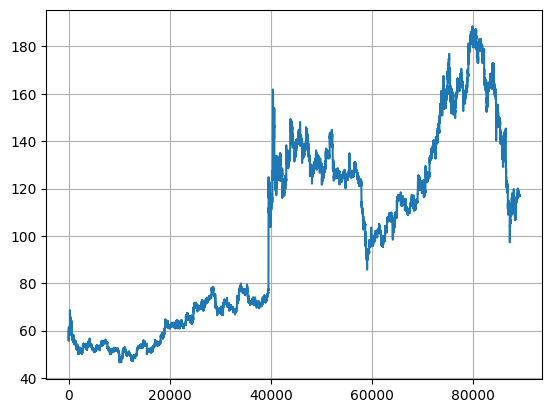

In [94]:
# Just make sure that this looks correct

plt.plot()
plt.grid()
plt.plot([val.open for val in response_list])
plt.show()

# Backtest strategy

In [95]:
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import copy
import numpy as np

In [96]:
def compute_quantities_itm(stock_price, strike_price, premium_value):
    buffer = (stock_price-strike_price)*100/stock_price
    premium_percentage = 100*(premium_value - (stock_price-strike_price))/stock_price
    
    return buffer, premium_percentage

In [97]:
def get_weekday(date_string):
    
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:])
    
    given_date = datetime(year, month, day)
    day_of_week = given_date.isoweekday()
        
    return day_of_week

In [98]:
def get_week_groups_invested_in_strategy(data, start_from_day = None):
    
    dict_days = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, 
                     "Saturday": 6, "Sunday": 7}
    days = np.array([get_weekday(element.date.split(" ")[0]) for element in data])
    
    if start_from_day is None:
        raise ValueError("Not a valid day.")
    
    integer_day_limit = dict_days[start_from_day]

    data_new = copy.deepcopy(data[days >= integer_day_limit])
    days_new = copy.deepcopy(days[days >= integer_day_limit])
    
    # we do not really use this one
    if start_from_day != "Friday":
    
        wanted_difference = dict_days["Friday"] - integer_day_limit

        diff_array = days_new[:-1] - days_new[1:]
        diff_array[np.where(diff_array != wanted_difference)[0]] = 0
        diff_array = np.insert(diff_array, 0, 0)
        diff_array[np.where(diff_array == wanted_difference)[0]] = 1
        
        diff_array = np.cumsum(diff_array)
        
    else:
        days = np.array([element.date.split(" ")[0] for element in data_new])
        groups, counts = np.unique(days, return_counts=True)
        
        diff_array = []
        for i in range(len(counts)):
            diff_array += [i]*counts[i]
        
    return diff_array, data_new, days_new

In [99]:
def get_week_groups_invested_in_stock(data, end_from_day):
    
    dict_days = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, 
                     "Saturday": 6, "Sunday": 7}
    days = np.array([get_weekday(element.date.split(" ")[0]) for element in data])
    integer_day_limit = dict_days[end_from_day]

    data_new = copy.deepcopy(data[days < integer_day_limit])
    days_new = copy.deepcopy(days[days < integer_day_limit])
    
    wanted_difference = (integer_day_limit-1) - 1
    
    diff_array = days_new[:-1] - days_new[1:]
    diff_array[np.where(diff_array != wanted_difference)[0]] = 0
    diff_array = np.insert(diff_array, 0, 0)
    diff_array[np.where(diff_array == wanted_difference)[0]] = 1
    
    return np.cumsum(diff_array), data_new, days_new

In [100]:
# this looks correct, double check still, in case

def compute_profit_otm(percentage_cumsum, premium, strategy):
    
    if strategy == "dynamic":
        crossed_low_threshold = False # here low_threshold is strike price
        crossed_high_threshold = False # here, crossed_high_threshold is strike price + premium

        for value in percentage_cumsum:

            if value < 0 and crossed_high_threshold: # this is correct
                crossed_low_threshold = True

            if value >= premium and (not crossed_high_threshold): # this is correct
                crossed_high_threshold = True

        if crossed_high_threshold and not crossed_low_threshold:
            if percentage_cumsum[-1] >= 0: # here, 0 is with respect to the strike price
                profit = 0 
        elif crossed_high_threshold and crossed_low_threshold:
            if percentage_cumsum[-1] <= 0:
                profit = 0
            elif percentage_cumsum[-1] > 0:
                profit = -percentage_cumsum[-1]

        # other cases:
        else:
            if percentage_cumsum[-1] <= 0:
                profit = premium
            else:
                profit = -percentage_cumsum[-1]+premium
        
    return profit

In [101]:
def compute_profit_itm(percentage_cumsum, premium, buffer, strategy):
    
    if strategy == "dynamic":
        crossed_low_threshold = False
        crossed_high_threshold = False

        for value in percentage_cumsum:

            if value <= -buffer and (not crossed_low_threshold):
                crossed_low_threshold = True # this means the price goes below the strike price 

            if value >= 0 and crossed_low_threshold:
                crossed_high_threshold = True # this means the price goes above the purchase price
                
        if crossed_low_threshold and not crossed_high_threshold:
            if percentage_cumsum[-1] <= -buffer:
                profit = premium
                # print("case 1 profit:", profit)
            elif percentage_cumsum[-1] > -buffer:
                profit = premium-(percentage_cumsum[-1]+buffer)
                # print("case 2 profit:", profit)
                
        elif crossed_low_threshold and crossed_high_threshold:
            if percentage_cumsum[-1] >= -buffer:
                profit = premium - buffer
                # print("case 3 profit:", profit)
            elif percentage_cumsum[-1] < -buffer:
                profit = premium + percentage_cumsum[-1]
                # print("case 4 profit:", profit)
        
        elif not crossed_low_threshold and not crossed_high_threshold:
            profit = premium
            # print("case 5 profit:", profit)
        
        else:
            raise ValueError("not all cases are captured!")
    
    # TODO: fix this
    elif strategy == "naked":
        if percentage_cumsum[-1] < -buffer:
            profit = premium+buffer
        elif percentage_cumsum[-1] > -buffer: 
            profit = premium - (percentage_cumsum[-1]+buffer)
            
    elif strategy == "covered":
        if percentage_cumsum[-1] <= -buffer:
            profit = premium+percentage_cumsum[-1]
        elif percentage_cumsum[-1] > -buffer:
            profit = premium
    
    else:
        raise ValueError(f"Strategy {strategy} is not valid.")
            
        
    return profit

In [41]:
ticker = "ARM"
day_of_interest = "Friday"

data_source = "polygon"  # "polygon" or "ibkr"

In [43]:
if data_source == "ibkr":
    candle = "1 min"
    period = "1 W"
    
    file_name = f"./historical_data/historical_data_onlyrth_{ticker}_candle_{candle}_period_{period}.p"
    data = np.array(pickle.load(open(file_name, "rb")))

elif data_source == "polygon":
    
    data = response_list
    
    if isinstance(data, list):
        data = np.array(data)
    
    
else:
    raise ValueError("Not a valid data_source")

In [45]:
groups_in_strat, data_in_strat, days_in_strat = get_week_groups_invested_in_strategy(data, day_of_interest)

In [46]:
groups_in_stock, data_in_stock, days_in_stock = get_week_groups_invested_in_stock(data, day_of_interest)

In [47]:
# Compute the return that we would make by investing in the stock while we are not running the strategy

def compute_returns_over_invested_days(data, groups):
    """Compute the overall returns by only being invested on certain days of the week."""
    starting_capital = 1
    for group in np.unique(groups):
        data_group = data[groups == group]
        price_at_purchase_time = data_group[0].open
        change = 100*(data_group[-1].close - data_group[0].open)/data_group[0].open
        starting_capital *= (1+change/100)
    
    return starting_capital

In [54]:
returns_invested = compute_returns_over_invested_days(data_in_stock, groups_in_stock)

In [55]:
print(returns_invested)

1.203756345177665


In [75]:
# compute the profit running the strategy for selling ITM calls


def compute_srategy_returns_itm(data, groups, stock_price, strike_price, premium_value, strategy, plotting=False):
    
    premium = ((premium_value-(stock_price-strike_price))/stock_price)*100
    buffer = 100*(stock_price-strike_price)/stock_price
    
    # print(f"premium: {premium}, buffer: {buffer}.")

    profit_list = []
    for group in np.unique(groups):
        data_group = data[groups == group]
        monday = data_group[0].date

        price_at_purchase_time = stock_price
        percentage_cumsum = [100*(element.close - price_at_purchase_time)/price_at_purchase_time for element in data_group]
        percentage_cumsum.insert(0, 0)
        # percentage_cumsum = np.cumsum(percentage_cumsum)

        profit = compute_profit_itm(percentage_cumsum, premium, buffer, strategy)
        
        if plotting:
            plt.plot()
            plt.grid(True)
            plt.plot(percentage_cumsum)
            plt.title(f"Profit={profit}.")
            plt.axhline(y=premium, color='darkgreen', linestyle='--', linewidth=2)
            plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2)
            plt.axhline(y=-buffer, color='darkblue', linestyle='--', linewidth=2)
            plt.legend(["Price change %", "Premium %", "Purchase price", "Strike Price %"])
            plt.show()

        profit_list.append((profit, monday))
        
    return profit_list


# compute the profit running the strategy for selling OTM calls

def compute_srategy_returns_otm(data, groups, strike_price, stock_price, premium_value, strategy, plotting=False):
    
    premium = (premium_value/strike_price)*100
    assert strike_price > stock_price, f"strike price {strike_price} is not greater than current price {stock_price}."
    ratio_current_strike = strike_price/stock_price
    
    profit_list = []
    for group in np.unique(groups):
        data_group = data[groups == group]
        monday = data_group[0].date
        current_price = data_group[0].open
        strike_price = current_price*(ratio_current_strike)
        
        percentage_cumsum = [100*(element.close - strike_price)/strike_price for element in data_group]
        percentage_cumsum.insert(0, 100*(data_group[0].open - strike_price)/strike_price)
        # print(percentage_cumsum)
        # percentage_cumsum = np.cumsum(percentage_cumsum)
        
        profit = compute_profit_otm(percentage_cumsum, premium, strategy)
        
        if plotting:
            plt.plot()
            plt.grid(True)
            plt.plot(percentage_cumsum)
            plt.title(f"Profit={profit}.")
            plt.axhline(y=premium, color='darkgreen', linestyle='--', linewidth=2)
            plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2)
            plt.legend(["Price change %", "Premium %", "Srike price"])
            plt.show()

        profit_list.append((profit, monday))
        
    return profit_list

In [76]:
option_itm_or_otm = "itm"
use_strategy = ["covered"]  # dynamic, naked, covered
plotting = True

stock_price = 119
strike_price = 119
premium_value = 1.86

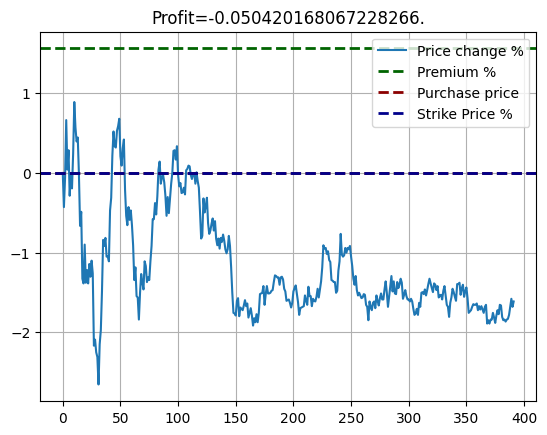

strategy covered -0.050420168067228266 -0.050420168067228266


In [77]:
if option_itm_or_otm == "itm":
    
    profit_dict = {}
    for strategy in use_strategy:
        profit_list = compute_srategy_returns_itm(data_in_strat, groups_in_strat, stock_price, 
                                                  strike_price, premium_value, strategy, plotting)
        
        profit_list = [value[0] for value in profit_list]
        print(f"strategy {strategy}", np.mean(profit_list), np.sum(profit_list))
        profit_dict[strategy] = profit_list
        
elif option_itm_or_otm == "otm":
    
    for strategy in use_strategy:
        profit_list = compute_srategy_returns_otm(data_in_strat, groups_in_strat, 
                                                  strike_price, stock_price, premium_value, strategy, plotting)
        
        profit_list = [value[0] for value in profit_list]
        print(np.mean(profit_list), np.sum(profit_list))
        
else:
    raise ValueError(f"should be 'itm' or 'otm', got {option_itm_or_otm}.")

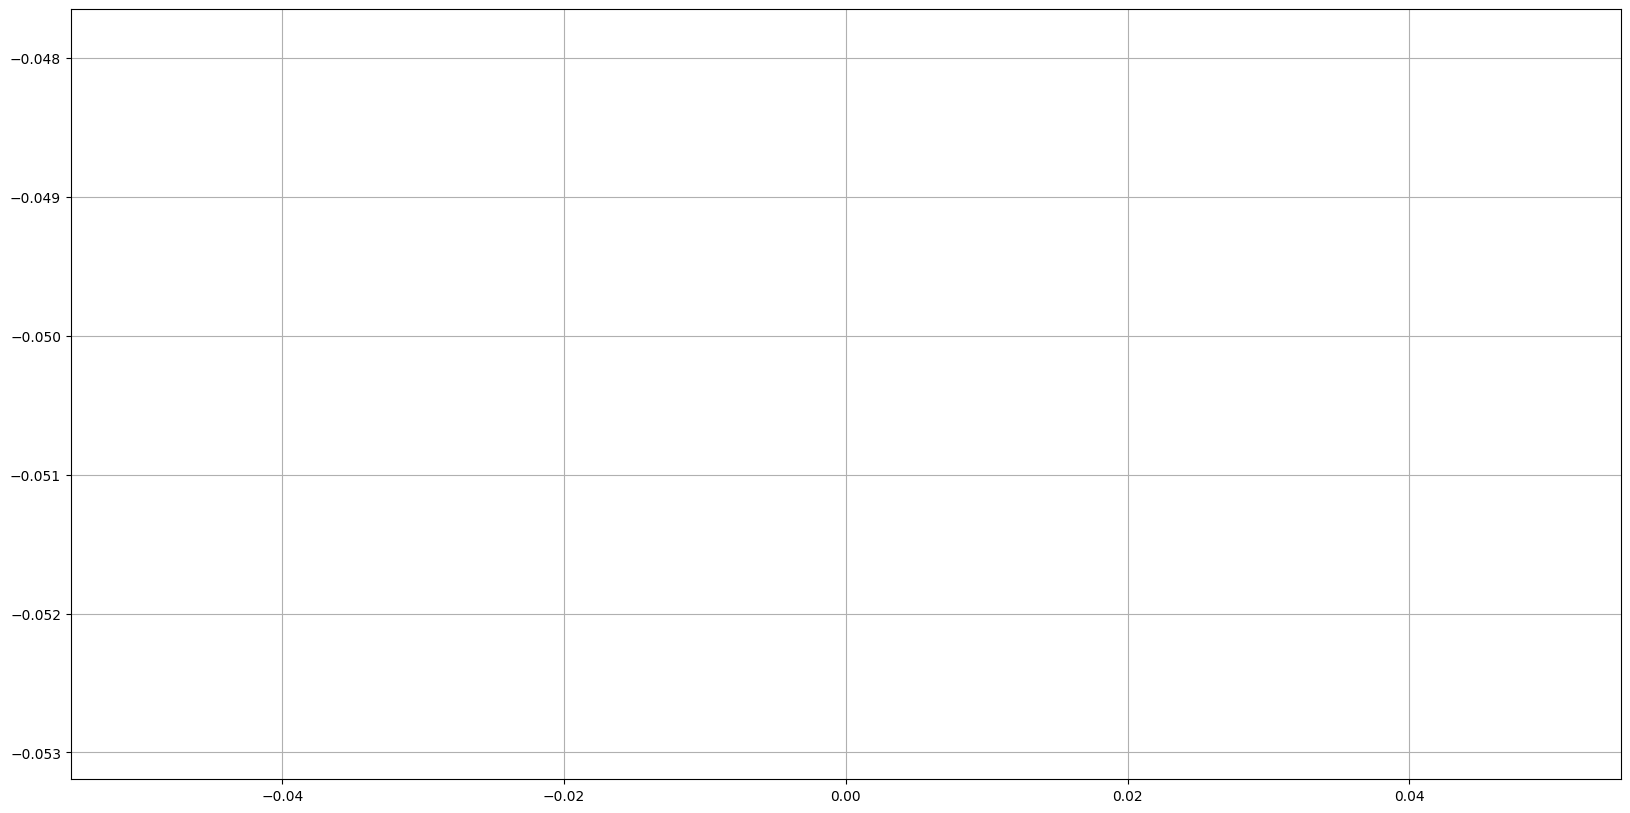

In [78]:
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.plot(profit_list)
plt.show()

In [68]:
print(len(profit_list), np.mean(profit_list))

81 1.3673209807493782


In [28]:
def compute_invested_and_compounded_returns(mean_profit):
    
    list_returns_spy = pickle.load(open("list_returns_spy.p", "rb"))
    
    compounded_return = np.sum((1+(np.array(list_returns_spy)/100))*mean_profit)
    
    return compounded_return

In [29]:
compounded_return = compute_invested_and_compounded_returns(np.mean(profit_list))

In [30]:
print(compounded_return)

180.29573293601828


In [32]:
returns_invested

1.9062111500673908

In [33]:
overall_return = returns_invested*100+compounded_return

In [34]:
overall_return

370.9168479427574

In [ ]:
# TODO: have a shortlist of stocks being monitored for their iv and iv/hv. This is probably better than having a
# strike price close to the current purchase price of the stock.
# selling named OTM is the way to go (better than deep ITM) ODTE.